# Distribution computation in C# accessed via REST-API for multiple events having multiple weighted outcomes

Computing the distribution allows to model **game design' specific payout-profiles**.
A general formula allows to determine the exact distribution on equally-distributed outcomes. A cycle-evaluation further allows to consider weighted-outcomes. With the help of the exact distribution and assuming a-priori-probabilities the RTP can be controlled exactly. Furthermore, modifying the outcome-probabilities resp. weights allows to fine-tune the RTP and additionally, tune the [**game behaviour**](https://nbviewer.jupyter.org/github/Gordi33/The-Laws-of-the-Game/blob/master/PlayersSurvivalWhenThrowingDices.ipynb). If the probabilities resp. weights fluctuate while keeping the payout-profile constant, then the RTP increases with the volatility of the weights. This is an important insight, if probabilities are only approximations resp. **implied probabilities** and not a-priori-probabilities, then the risk of having a higher RTP increases.
 
 - Part 3: Deriving a general formula for a fixed number of equally-distributed outcomes for each event. Creating a game specific payout for events having equally-distributed outcomes based on the distribution.
 - Part 4: Cycle evaluation for a fixed number of events with weighted-outcomes in **C# accessed via REST-API**. Creating a game specific payout for events having weighted outcomes based on the distribution. Here,
 - Part5: RTP' impact of the different scenarios for increased volatility on the weights.

# Imports

In [78]:
import sys
sys.path.insert(0, 'lib\\')
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import scipy.special
import requests
from timeit import default_timer as timer
import urllib3
urllib3.disable_warnings()
import json
import random

# Deriving a general formula for a fixed number of events with equally-distributed outcomes
Part 3: Deriving a formula for computing the hits and the probabilities for a fixed number of dices, having a fixed number of equally-distributed outcomes.

For getting a better modelling understanding it is recommended to read [**CombinatorialThinking**](https://nbviewer.jupyter.org/github/Gordi33/Mathematical-Problems/blob/master/CombinatorialThinking%20.ipynb).

Let numOutcomes be the number of outcomes for each event and let numEvent be the number of events resp. dices.

 - The total cycle represents all combinations and can be evaluated by:

$$ totalCycle = {numOutcomes}^{numEvents}$$

For example, having 9 dices and each dice has 10 different outcomes leads to a total cycle of:

In [2]:
numEvents = 9
numOutcomes = 10
totalCycle = numOutcomes**numEvents
print(f"{totalCycle:,}")

1,000,000,000


The number of hits, denoted by k, can be evaluated by:
 
$$hits(k) = \binom{numEvents}{k} * {(numOutcomes-1)}^{(numEvents - k)}$$

--- 
This fact derives out of the following:
- Firstly, the number of hits resp. correct scores out of a given number of events is determined by the binomial coefficient. For example, having 2 hits on 9 dices with 10 outcomes leads to 36 different hit-combinations:

$$\binom{9}{2} = 36$$

- Secondly, for each hit-combination, the other dices need to cycle through all no-hit-combinations i.e., which do not lead to another hit. The number of no-hits on a dice is simply (numOutcomes - 1) and the number of dices, which show no-hit is (numEvent - k). Continuing with the example determines 7 no-hits dices and, on each 9 outcomes with no-hit:

$${(10-1)}^{(9 - 2)} = {(9)}^{(7)} = 4,782,969 $$

- Thirdly, the product determines the total success-hits within the cycle. For 2 hits with 9 dices having 10 outcomes:
   
$$\binom{9}{2} * {(10-1)}^{(9 - 2)} = 36 * 4,782,969 = 172,186,884 $$

---

Summing up all hits, for k = 0,...,numEvents; leads to

$$ totalCycle = {numOutcomes}^{numEvents} = \sum_{k=0}^{numEvents} \binom{numEvents}{k} * {(numOutcomes-1)}^{(numEvents - k)}$$ 


The probability of having k hits is then simply the ratio:

$$P(X=k) = \frac{hits(k)}{totalCycle} = \frac{\binom{numEvents}{k} * {(numOutcomes-1)}^{(numEvents - k)}}{{numOutcomes}^{numEvents}}$$
  

Continuing with the example, the probability of having 2 hits on 9 dices with 10 outcomes:
  
$$P(X=2) = \frac{\binom{9}{2} * {(10-1)}^{(9 - 2)}}{{10}^{9}} = 0.172186884 $$

In [3]:
temp = [[0 for x in range(numEvents+1)] for y in range(5)]
acc_hits = 0

for i in range(numEvents+1):
    temp[0][i] = scipy.special.binom(numEvents, i)
    temp[1][i] = (numOutcomes-1)**(numEvents - i)
    temp[2][i] = temp[0][i] * temp[1][i]
    acc_hits = acc_hits + temp[2][i] 
    temp[3][i] = acc_hits
    temp[4][i] = temp[2][i] *1.0 / totalCycle * 1.0

pd.options.display.float_format = '{:,.0f}'.format  
df = pd.DataFrame(temp).transpose().rename(columns={0: "Number of different combinations of hits, which lead to k hits", 
                                               1: "Number of different combinations of no-hits",
                                               2: "Total hits for k",
                                               3: "Accumulated hits", 
                                               4: "P(X)"})
df['P(X)'] = df['P(X)'].map('{:,.9f}'.format)
df

,"Number of different combinations of hits, which lead to k hits",Number of different combinations of no-hits,Total hits for k,Accumulated hits,P(X)
0,1,"387,420,489","387,420,489","387,420,489",0.387420489
1,9,"43,046,721","387,420,489","774,840,978",0.387420489
2,36,"4,782,969","172,186,884","947,027,862",0.172186884
3,84,"531,441","44,641,044","991,668,906",0.044641044
4,126,"59,049","7,440,174","999,109,080",0.007440174
5,126,"6,561","826,686","999,935,766",0.000826686
6,84,729,"61,236","999,997,002",0.000061236
7,36,81,"2,916","999,999,918",0.000002916
8,9,9,81,"999,999,999",0.000000081
9,1,1,1,"1,000,000,000",0.000000001


## Creating a game specific payout for events having equally-distributed outcomes based on the distribution

Part 3.1.: Creating a game based on the distribution allows to award a specific win to each category. Each category has its probability density due to the previous computation. With a given win and a given probability the category's **return-to-player** can be computed. The game's stake is 1 and game's **return-to-player** should be <100%.

In [4]:
payouts = [0.0,0.0,1.0,5.0,50.0,100.0,1000.0,10000.0,100000.0,1000000.0]
df['Payouts'] = payouts
df

,"Number of different combinations of hits, which lead to k hits",Number of different combinations of no-hits,Total hits for k,Accumulated hits,P(X),Payouts
0,1,"387,420,489","387,420,489","387,420,489",0.387420489,0
1,9,"43,046,721","387,420,489","774,840,978",0.387420489,0
2,36,"4,782,969","172,186,884","947,027,862",0.172186884,1
3,84,"531,441","44,641,044","991,668,906",0.044641044,5
4,126,"59,049","7,440,174","999,109,080",0.007440174,50
5,126,"6,561","826,686","999,935,766",0.000826686,100
6,84,729,"61,236","999,997,002",0.000061236,"1,000"
7,36,81,"2,916","999,999,918",0.000002916,"10,000"
8,9,9,81,"999,999,999",0.000000081,"100,000"
9,1,1,1,"1,000,000,000",0.000000001,"1,000,000"


For each hit-category a fictious payout based on the game's distribution is defined. The **hold** resp. margin, which is defined by 1-RTP is achieved by downgrading each hit-category further. 

The RTP is then simply defined by:


$$ RTP = \sum_{k=0}^{numEvents} Payouts(k) * P(X=k)$$   

In [5]:
df['RTP of k hits'] = df['Payouts'].astype(float) * df['P(X)'].astype(float)
df['RTP of k hits'] = df['RTP of k hits'].map('{:,.9f}'.format)
df
print('RTP =', df['RTP of k hits'].astype(float).sum())

RTP = 0.949565404


The next chapter shows a solution considering weighted outcomes. Weighted outcomes allow to consider events with different outcome-probabilities, which is a more flexible and realistic approach.
Additionally, the RTP and the [**game behaviour**](https://nbviewer.jupyter.org/github/Gordi33/The-Laws-of-the-Game/blob/master/PlayersSurvivalWhenThrowingDices.ipynb) can be modified via this.

 - Increasing the RTP can be achieved via increasing the probabilities of the categories which have a return.

# Cycle evaluation for a fixed number of events with weighted-outcomes in C# accessed via REST-API
Part 4: Applying the cycle-evaluation in **C# accessed via REST-API** with szenario analysis for the weights. 
What happens with the RTP, if the events aren't equally-distributed ?

How does the algorithm in C# work ?
The algorithm expects for each event an array with equal length for all events.

Let the events be defined by *j*=1,...,*numEvents* and 
the event' outcomes by *i*=1,...,*numOutcomes*. 

This array represents the event' weights and the array' index is the according outcome. The weights need to be positive integer values. The events and their weights are set up as an array of Json-objects (expected input). 

Algorithm:

- Firstly, weights for each event are normalised. For each event the normalisation is applied via

$$ P(i^{th} \hspace{2mm}  outcome \hspace{2mm} of \hspace{2mm} j^{th} \hspace{2mm} event) =  \frac{Weight(i,j)}{\sum_{i=1}^{numOutcomes}Weight(i,j)}$$   

- Secondly, for each event the outcome with the maximum outcome' probability is chosen. If there is more than one maximum then the one with the lowest index is chosen. This combination of maximum outcome'probability represents the comabination, which is considered as the correct one. Let this combination be maximum likelihood estimation' combination denoted with MLE-combination.
 
- Thirdly, the total-cycle is evaluated.

$$ totalCycle = {numOutcomes}^{numEvents}$$

Note that the time complexity is O(numOutcomes^numEvents). Each combinations' probability is added to the category of correct hits according the MLE-combination as well as the correct hits.
    
Pseudo code
 
    do 
    {
          computeCombinationProbability()
          computeCombinationHits()
          addProbabilityToTheCorrectNumberOfHitsCategory()
          incrementHitsCategoryForTheCorrectNumberOfHitsByOne()
          getNextCombinationInCycle()    
    } while (totalCycleIsNotCompletedYet)

## Cycle evaluation for equally-distributed weights
Part 4.1: Creating a JSON-object with the weights, defining the post-request and converting the output to a dataframe.

In [81]:
def getJsonEvents(delta): 
    events  = []
    for event in range(0,9):
        events.append({ "weights": [random.randint(1000-delta,1000+delta) for i in range(0,10)]})
    return events

events = getJsonEvents(0)
events

[{'weights': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]},
 {'weights': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]},
 {'weights': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]},
 {'weights': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]},
 {'weights': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]},
 {'weights': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]},
 {'weights': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]},
 {'weights': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]},
 {'weights': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]}]

In [8]:
def postRequestsObject(url, events):
    start = timer()
    response = requests.post(url, json = events, verify=False)
    end = timer()
    print('Time in seconds: ', end - start)
    return json.loads(response.text)

In [9]:
postRequestsObjectEqDist = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  20.043250599999737


In [45]:
def convertJsonIntoDataFrame(responseJson, numberOfEvents, payouts):
    df_weighted = pd.DataFrame([responseJson[i]['correctEventsCategory'] for i in range(0,numberOfEvents)]).rename(columns={0: "CorrectEventsCategory"})
    df_weighted['Probability'] = [responseJson[i]['probability'] for i in range(0,numberOfEvents)]
    df_weighted['Hits'] = [responseJson[i]['hits'] for i in range(0,numberOfEvents)]
    df_weighted['Probability'] = df_weighted['Probability'].astype(float).map('{:,.15f}'.format)
    df_weighted['Payouts'] = payouts
    df_weighted['RTP_of_k_hits'] = df_weighted['Payouts'].astype(float) * df_weighted['Probability'].astype(float)
    df_weighted['RTP_of_k_hits'] = df_weighted['RTP_of_k_hits'].map('{:.15f}'.format)
    return df_weighted

In [11]:
df_weighted_equally = convertJsonIntoDataFrame(postRequestsObjectEqDist, len(events)+1, payouts)
df_weighted_equally

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.387420492615447,387420489,0,0.000000000000000
1,1,0.387420492615447,387420489,0,0.000000000000000
2,2,0.172186883914551,172186884,1,0.172186883914551
3,3,0.044641043981686,44641044,5,0.223205219908430
4,4,0.007440174000944,7440174,50,0.372008700047200
5,5,0.000826686000008,826686,100,0.082668600000800
6,6,0.000061236000000,61236,"1,000",0.061236000000000
7,7,0.000002916000000,2916,"10,000",0.029160000000000
8,8,0.000000081000000,81,"100,000",0.008100000000000
9,9,0.000000001000000,1,"1,000,000",0.001000000000000


Figures match the theoretical figures out of (3).

In [12]:
print('Probability =', round(df_weighted_equally['Probability'].astype(float).sum(),4))
print('Hits        =', round(df_weighted_equally['Hits'].astype(float).sum(),4))
print('RTP         =', round(df_weighted_equally['RTP_of_k_hits'].astype(float).sum(),18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 0.949565403870981


With equally-distributed weights for all outcomes the RTP is 94,96%.

## Cycle evaluation for modified weights - weights fluctuate by +/- 1.
If the weights fluctuate by +/- 1. Having that super low fluctuation, what is the impact on the RTP ?

In [82]:
events = getJsonEvents(1)
events

[{'weights': [999, 1001, 1000, 999, 999, 999, 1001, 999, 1000, 1001]},
 {'weights': [1001, 1000, 1001, 999, 1000, 1001, 999, 1001, 1001, 1000]},
 {'weights': [1000, 999, 1000, 1000, 1000, 1000, 1000, 1000, 1001, 1000]},
 {'weights': [1001, 1000, 999, 1000, 1001, 1001, 1000, 1000, 999, 1000]},
 {'weights': [999, 1000, 1001, 1000, 1000, 1001, 1001, 1001, 1001, 1001]},
 {'weights': [1001, 1001, 1001, 999, 1000, 1001, 999, 1001, 1001, 1000]},
 {'weights': [1001, 1000, 1000, 999, 1000, 999, 999, 999, 1000, 999]},
 {'weights': [1001, 999, 999, 1001, 999, 999, 1001, 999, 1000, 1000]},
 {'weights': [1000, 1000, 1001, 1000, 1000, 1001, 1000, 999, 1001, 999]}]

In [14]:
responseJsonSz1 = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  17.232177100000172


In [15]:
df_weightedSz1 = convertJsonIntoDataFrame(responseJsonSz1, len(events)+1, payouts)
df_weightedSz1

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.387046138188919,387420489,0,0.000000000000000
1,1,0.387461904761103,387420489,0,0.000000000000000
2,2,0.172390274415854,172186884,1,0.172390274415854
3,3,0.044741784535520,44641044,5,0.223708922677600
4,4,0.007464974258090,7440174,50,0.373248712904500
5,5,0.000830332553634,826686,100,0.083033255363400
6,6,0.000061572183305,61236,"1,000",0.061572183305000
7,7,0.000002935158195,2916,"10,000",0.029351581950000
8,8,0.000000081619751,81,"100,000",0.008161975100000
9,9,0.000000001008734,1,"1,000,000",0.001008734000000


In [16]:
print('Probability =', round(df_weightedSz1['Probability'].astype(float).sum(), 4))
print('Hits        =', round(df_weightedSz1['Hits'].astype(float).sum(), 4))
print('RTP         =', round(df_weightedSz1['RTP_of_k_hits'].astype(float).sum(), 18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 0.9524756397163541


With a weight fluctuation of +/-1 of intially 1000 the RTP increased from 94,96% to 95,25%.

## Cycle evaluation for modified weights - weights fluctuate by +/- 10.
If the weights fluctuate by +/- 10. Having that low fluctuation, what is the impact on the RTP ?

In [17]:
events = getJsonEvents(10)
events

[{'weights': [1006, 1000, 1000, 1008, 1000, 1004, 1001, 990, 999, 1008]},
 {'weights': [1005, 1001, 1002, 1007, 991, 1005, 1004, 1000, 1003, 1005]},
 {'weights': [1001, 1006, 1010, 998, 998, 997, 992, 1003, 996, 995]},
 {'weights': [1002, 996, 1003, 993, 1007, 992, 999, 990, 996, 1010]},
 {'weights': [990, 996, 1010, 1000, 1008, 1005, 1002, 1002, 1010, 1000]},
 {'weights': [1003, 990, 998, 1004, 1005, 999, 999, 1009, 990, 1009]},
 {'weights': [1006, 998, 990, 1003, 1003, 1001, 993, 1008, 996, 994]},
 {'weights': [993, 993, 996, 997, 997, 1000, 1009, 999, 1008, 996]},
 {'weights': [1007, 1009, 993, 998, 998, 995, 1002, 998, 991, 996]}]

In [18]:
responseJsonSz10 = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  17.39366149999978


In [19]:
df_weightedSz10 = convertJsonIntoDataFrame(responseJsonSz10, len(events)+1, payouts)
df_weightedSz10

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.384071107820509,387420489,0,0.000000000000000
1,1,0.387778393807025,387420489,0,0.000000000000000
2,2,0.174009432171953,172186884,1,0.174009432171953
3,3,0.045548963341785,44641044,5,0.227744816708925
4,4,0.007664757328053,7440174,50,0.383237866402650
5,5,0.000859858112765,826686,100,0.085985811276500
6,6,0.000064307799452,61236,"1,000",0.064307799452000
7,7,0.000003091823606,2916,"10,000",0.030918236060000
8,8,0.000000086712617,81,"100,000",0.008671261700000
9,9,0.000000001080854,1,"1,000,000",0.001080854000000


In [20]:
print('Probability =', round(df_weightedSz10['Probability'].astype(float).sum(), 4))
print('Hits        =', round(df_weightedSz10['Hits'].astype(float).sum(), 4))
print('RTP         =', round(df_weightedSz10['RTP_of_k_hits'].astype(float).sum(), 18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 0.9759560777720281


With a weight fluctuation of +/-10 of initially 1000 the RTP increased from 94,96% to 97,60%.

## Cycle evaluation for modified weights - weights fluctuate by +/- 100.
If the weights fluctuate by +/- 10. Having that high fluctuation, what is the impact on the RTP ?

In [83]:
events = getJsonEvents(100)
events

[{'weights': [1064, 1048, 1068, 954, 957, 923, 1088, 1086, 1066, 1088]},
 {'weights': [959, 908, 1068, 1052, 1023, 916, 938, 1080, 942, 942]},
 {'weights': [903, 1085, 949, 1066, 977, 1074, 982, 1089, 1070, 986]},
 {'weights': [1087, 1100, 1080, 1077, 901, 943, 940, 1027, 1038, 910]},
 {'weights': [1022, 1029, 1014, 957, 919, 927, 965, 901, 916, 958]},
 {'weights': [987, 1079, 1029, 942, 1063, 1024, 972, 986, 1037, 922]},
 {'weights': [1012, 1085, 1060, 1078, 1039, 1071, 939, 925, 912, 1060]},
 {'weights': [1070, 979, 1043, 912, 1039, 900, 984, 997, 1054, 932]},
 {'weights': [978, 996, 1074, 951, 964, 915, 1035, 1069, 945, 1050]}]

In [22]:
responseJsonSz100 = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  17.484811499999978


In [51]:
df_weightedSz100 = convertJsonIntoDataFrame(responseJsonSz100, len(events)+1, payouts)
df_weightedSz100

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.354756154051323,387420489,0,0.000000000000000
1,1,0.389659941309966,387420489,0,0.000000000000000
2,2,0.190204922261838,172186884,1,0.190204922261838
3,3,0.054154852777799,44641044,5,0.270774263888995
4,4,0.009911296672985,7440174,50,0.495564833649250
5,5,0.001209192530919,826686,100,0.120919253091900
6,6,0.000098340511421,61236,"1,000",0.098340511421000
7,7,0.000005140997202,2916,"10,000",0.051409972020000
8,8,0.000000156762661,81,"100,000",0.015676266100000
9,9,0.000000002124316,1,"1,000,000",0.002124316000000


In [24]:
print('Probability =', round(df_weightedSz100['Probability'].astype(float).sum(), 4))
print('Hits        =', round(df_weightedSz100['Hits'].astype(float).sum(), 4))
print('RTP         =', round(df_weightedSz100['RTP_of_k_hits'].astype(float).sum(), 18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 1.245014338432983


With a weight fluctuation of +/-1 of initially 1000 the RTP increased from 94,96% to 122,87%.

## Cycle evaluation for modified weights - weights fluctuate by +/- 1000.
If the weights fluctuate by +/- 1000. Having that very high fluctuation, what is the impact on the RTP ?

In [84]:
events = getJsonEvents(1000)
events

[{'weights': [730, 245, 430, 375, 840, 866, 1349, 1533, 1237, 211]},
 {'weights': [1249, 1312, 222, 1011, 318, 1509, 1847, 456, 408, 1705]},
 {'weights': [1151, 721, 1668, 1965, 847, 1222, 650, 1280, 1056, 673]},
 {'weights': [919, 614, 1904, 714, 880, 1317, 456, 1180, 740, 1894]},
 {'weights': [616, 1592, 821, 632, 1180, 1753, 2, 1877, 539, 1192]},
 {'weights': [817, 582, 1323, 1900, 19, 1431, 793, 1055, 943, 1272]},
 {'weights': [1484, 578, 1562, 640, 283, 957, 97, 889, 1337, 84]},
 {'weights': [43, 1085, 1814, 641, 203, 13, 904, 1163, 721, 652]},
 {'weights': [712, 613, 461, 1305, 1602, 1887, 1089, 529, 411, 1073]}]

In [26]:
responseJsonSz1000 = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  17.595283999999992


In [50]:
df_weightedSz1000 = convertJsonIntoDataFrame(responseJsonSz1000, len(events)+1, payouts)
df_weightedSz1000

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.165596267759370,387420489,0,0.000000000000000
1,1,0.330670856351651,387420489,0,0.000000000000000
2,2,0.292152628317432,172186884,1,0.292152628317432
3,3,0.149907141921733,44641044,5,0.749535709608665
4,4,0.049233733671847,7440174,50,2.461686683592350
5,5,0.010733888934343,826686,100,1.073388893434300
6,6,0.001553590243750,61236,"1,000",1.553590243750000
7,7,0.000143958342445,2916,"10,000",1.439583424450000
8,8,0.000007749776904,81,"100,000",0.774977690400000
9,9,0.000000184680569,1,"1,000,000",0.184680569000000


In [28]:
print('Probability =', round(df_weightedSz1000['Probability'].astype(float).sum(), 4))
print('Hits        =', round(df_weightedSz1000['Hits'].astype(float).sum(), 4))
print('RTP         =', round(df_weightedSz1000['RTP_of_k_hits'].astype(float).sum(), 18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 8.529595842552746


With a weight fluctuation of +/-1 of initially 1000 the RTP increased from 94,96% to 852,96%.

## Cycle evaluation for modified weights - one event' outcome being five-times overweight
If one outcome is five-times weighted as the other event' outcomes. Having that skewness in the weights, what is the impact on the RTP ?

In [86]:
def getJsonEvents(overweight): 
    events  = []
    for event in range(0,9):
        events.append({ "weights": [overweight,1,1,1,1,1,1,1,1,1]})
    return events

events = getJsonEvents(5)
events

[{'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [5, 1, 1, 1, 1, 1, 1, 1, 1, 1]}]

In [37]:
responseJsonSzX5 = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  18.393648199999916


In [49]:
df_weightedSzX5 = convertJsonIntoDataFrame(responseJsonSzX5, len(events)+1, payouts)
df_weightedSzX5

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.018751251746698,387420489,0,0.000000000000000
1,1,0.093756259240041,387420489,0,0.000000000000000
2,2,0.208347241303105,172186884,1,0.208347241303105
3,3,0.270079757336929,44641044,5,1.350398786684645
4,4,0.225066464370843,7440174,50,11.253323218542150
5,5,0.125036924652537,826686,100,12.503692465253700
6,6,0.046309972093995,61236,"1,000",46.309972093995000
7,7,0.011026183831907,2916,"10,000",110.261838319069994
8,8,0.001531414421098,81,"100,000",153.141442109800010
9,9,0.000094531754389,1,"1,000,000",94.531754389000000


In [39]:
print('Probability =', round(df_weightedSzX5['Probability'].astype(float).sum(), 4))
print('Hits        =', round(df_weightedSzX5['Hits'].astype(float).sum(), 4))
print('RTP         =', round(df_weightedSzX5['RTP_of_k_hits'].astype(float).sum(), 18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 429.56076862364864


With one outcome of each event being five-times as big as the other outcomes the RTP increased from 94,96% to 42956,07%.

## Cycle evaluation for modified weights - one event' outcome being hundred-times overweight
If one outcome is hundred-times weighted as the other event' outcomes. Having that skewness in the weights, what is the impact on the RTP ?

In [87]:
events = getJsonEvents(100)
events

[{'weights': [100, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [100, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [100, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [100, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [100, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [100, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [100, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [100, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
 {'weights': [100, 1, 1, 1, 1, 1, 1, 1, 1, 1]}]

In [60]:
responseJsonSzX100 = postRequestsObject('https://localhost:44339/api/Distribution', events)

Time in seconds:  18.608468000000357


In [61]:
df_weightedSzX100 = convertJsonIntoDataFrame(responseJsonSzX100, len(events)+1, payouts)
df_weightedSzX100

,CorrectEventsCategory,Probability,Hits,Payouts,RTP_of_k_hits
0,0,0.000000000178379,387420489,0,0.000000000000000
1,1,0.000000017837916,387420489,0,0.000000000000000
2,2,0.000000792796246,172186884,1,0.000000792796246
3,3,0.000020553976770,44641044,5,0.000102769883850
4,4,0.000342566279390,7440174,50,0.017128313969500
5,5,0.003806291993300,826686,100,0.380629199330000
6,6,0.028194755506481,61236,"1,000",28.194755506481002
7,7,0.134260740506955,2916,"10,000",1342.607405069549941
8,8,0.372946501408205,81,"100,000",37294.650140820500383
9,9,0.460427779516301,1,"1,000,000",460427.779516301001422


In [62]:
print('Probability =', round(df_weightedSzX10['Probability'].astype(float).sum(), 4))
print('Hits        =', round(df_weightedSzX10['Hits'].astype(float).sum(), 4))
print('RTP         =', round(df_weightedSzX10['RTP_of_k_hits'].astype(float).sum(), 18))

Probability = 1.0
Hits        = 1000000000.0
RTP         = 499093.6296787735


With one outcome of each event being hundred-times as big as the other outcomes the RTP increased from 94,96% to 49909362,96%.

# Impact of different scenarios for increased volatility on the weights.
Part 5. Comparison of the different scenarios.

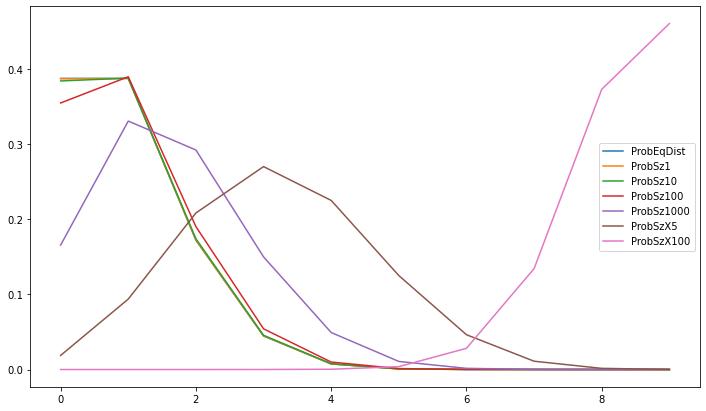

In [88]:
df_Probabilities = pd.concat([
           df_weighted_equally[['Probability']].astype(float).rename(columns={"Probability": "ProbEqDist"}),
           df_weightedSz1[['Probability']].astype(float).rename(columns={"Probability": "ProbSz1"}),
           df_weightedSz10[['Probability']].astype(float).rename(columns={"Probability": "ProbSz10"}),
           df_weightedSz100[['Probability']].astype(float).rename(columns={"Probability": "ProbSz100"}),
           df_weightedSz1000[['Probability']].astype(float).rename(columns={"Probability": "ProbSz1000"}),
           df_weightedSzX5[['Probability']].astype(float).rename(columns={"Probability": "ProbSzX5"}),
           df_weightedSzX100[['Probability']].astype(float).rename(columns={"Probability": "ProbSzX100"})]
        ,axis=1)

df_Probabilities.plot(figsize=(12,7))
plt.show()

Increasing the volatility on the weights leads to overweighing one event' outcome and this leads again in having more probability on the higher hit-categories. The distribution changes from right-skewed to symmetric to left-skewed for having outstanding event' outcome probability.

In [66]:
pd.options.display.float_format = "{:,.10f}".format
df_Probabilities

,ProbEqDist,ProbSz1,ProbSz10,ProbSz100,ProbSz1000,ProbSzX5,ProbSzX100
0,0.3874204926,0.3870461382,0.3840711078,0.3547561541,0.1655962678,0.0187512517,0.0000000002
1,0.3874204926,0.3874619048,0.3877783938,0.3896599413,0.3306708564,0.0937562592,0.0000000178
2,0.1721868839,0.1723902744,0.1740094322,0.1902049223,0.2921526283,0.2083472413,0.0000007928
3,0.0446410440,0.0447417845,0.0455489633,0.0541548528,0.1499071419,0.2700797573,0.0000205540
4,0.0074401740,0.0074649743,0.0076647573,0.0099112967,0.0492337337,0.2250664644,0.0003425663
5,0.0008266860,0.0008303326,0.0008598581,0.0012091925,0.0107338889,0.1250369247,0.0038062920
6,0.0000612360,0.0000615722,0.0000643078,0.0000983405,0.0015535902,0.0463099721,0.0281947555
7,0.0000029160,0.0000029352,0.0000030918,0.0000051410,0.0001439583,0.0110261838,0.1342607405
8,0.0000000810,0.0000000816,0.0000000867,0.0000001568,0.0000077498,0.0015314144,0.3729465014
9,0.0000000010,0.0000000010,0.0000000011,0.0000000021,0.0000001847,0.0000945318,0.4604277795


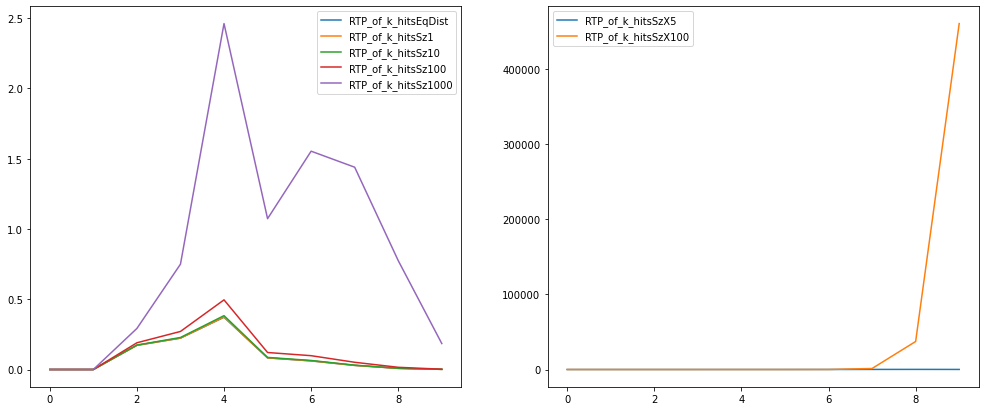

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2)
df_RTP_of_k_hits = pd.concat([
           df_weighted_equally[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsEqDist"}),
           df_weightedSz1[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsSz1"}),
           df_weightedSz10[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsSz10"}),
           df_weightedSz100[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsSz100"}),
           df_weightedSz1000[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsSz1000"}),  
           df_weightedSzX5[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsSzX5"}),
           df_weightedSzX100[['RTP_of_k_hits']].astype(float).rename(columns={"RTP_of_k_hits": "RTP_of_k_hitsSzX100"})
        ],axis=1)

df_RTP_of_k_hits[['RTP_of_k_hitsEqDist','RTP_of_k_hitsSz1','RTP_of_k_hitsSz10','RTP_of_k_hitsSz100','RTP_of_k_hitsSz1000']].plot(figsize=(18,7), ax=axes[0])
df_RTP_of_k_hits[['RTP_of_k_hitsSzX5','RTP_of_k_hitsSzX100']].plot(figsize=(17,7), ax=axes[1])
plt.show()

The categories' RTP increases enormously due to the increased categories' probabilities.

In [90]:
df_RTP_of_k_hits

,RTP_of_k_hitsEqDist,RTP_of_k_hitsSz1,RTP_of_k_hitsSz10,RTP_of_k_hitsSz100,RTP_of_k_hitsSz1000,RTP_of_k_hitsSzX5,RTP_of_k_hitsSzX100
0,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
2,0.1721868839,0.1723902744,0.1740094322,0.1902049223,0.2921526283,0.2083472413,0.0000007928
3,0.2232052199,0.2237089227,0.2277448167,0.2707742639,0.7495357096,1.3503987867,0.0001027699
4,0.3720087000,0.3732487129,0.3832378664,0.4955648336,2.4616866836,11.2533232185,0.0171283140
5,0.0826686000,0.0830332554,0.0859858113,0.1209192531,1.0733888934,12.5036924653,0.3806291993
6,0.0612360000,0.0615721833,0.0643077995,0.0983405114,1.5535902437,46.3099720940,28.1947555065
7,0.0291600000,0.0293515820,0.0309182361,0.0514099720,1.4395834245,110.2618383191,"1,342.6074050695"
8,0.0081000000,0.0081619751,0.0086712617,0.0156762661,0.7749776904,153.1414421098,"37,294.6501408205"
9,0.0010000000,0.0010087340,0.0010808540,0.0021243160,0.1846805690,94.5317543890,"460,427.7795163010"
